Toulouse INSEE : 31555
Code cours eau garonne en aval de Garonne = O---0000

1ere API

API qualite rivières :
https://hubeau.eaufrance.fr/api/v1/qualite_rivieres/analyse_pc

Exemple utilisation : 
https://hubeau.eaufrance.fr/api/v1/qualite_rivieres/analyse_pc?code_cours_eau=O---0000&date_debut_prelevement=1993-06-10&date_fin_prelevement=1993-06-17

Documentation :
https://hubeau.eaufrance.fr/page/api-qualite-cours-deau


_________________________________________________________________________________________________


2nde API

API georisques : 
https://www.georisques.gouv.fr/api/v1/gaspar/catnat

Exemple utilisation :
https://www.georisques.gouv.fr/api/v1/gaspar/catnat?code_insee=31555&page=2

Documentation :
https://www.georisques.gouv.fr/doc-api#/CATNAT

La page n'est pas obligatoire mais est pratique pour naviguer entre les résultats.


-------------------------------RECUPERATION DES DATES DES INNONDATIONS A TOULOUSE------------------------------

In [1]:
import re
import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

In [2]:
def remplir_dates(dates,doc):
    for document in reponse.json()['data']:
        if re.search("^Inondations.*",document['libelle_risque_jo']):
            dates.append(document['date_debut_evt'])
            dates.append(document['date_fin_evt'])
    return dates



endpoint = "https://www.georisques.gouv.fr/api/v1/gaspar/catnat"
params = {"code_insee":31555}
reponse = requests.get(endpoint,params)
##Les paires sont le début , impairs fin de l'événement
dates = []

if (reponse.status_code == 200):
    nb_pages = reponse.json()['total_pages']
    dates = remplir_dates(dates,reponse.json())

    ## itération sur les pages restantes
    if (nb_pages > 1):
        for x in range (2,nb_pages+1):
            params['page']=x
            reponse = requests.get(endpoint,params)
            if (reponse.status_code == 200):
                dates= remplir_dates(dates,reponse.json())
            else:
                print("Erreur requête itération")
    
else:
    print("Erreur premiere requête")

-------------------------------TRANSFORMATION DES DATES------------------------------

In [3]:
def calculer_intervalles(date_param):
    from datetime import date, timedelta
    dates = []
    cur_date = date(int(date_param[2]),int(date_param[1]),int(date_param[0]))
    delta_bornes = timedelta(days=15)
    borne_sup = cur_date+delta_bornes
    borne_inf = cur_date-delta_bornes
    dates.append(borne_inf.isoformat())
    dates.append(borne_sup.isoformat())
    return dates

new_dates = []
date_abscisses = []
for date in dates:
    cur_date = re.split('/',date)
    cur_date_iso = cur_date[2]+"-"+cur_date[1]+"-"+cur_date[0]
    date_abscisses.append(cur_date_iso)
    intervalle = calculer_intervalles(cur_date)
    if intervalle not in new_dates:
        new_dates.append(intervalle)
#print(new_dates)

-------------------------------RECUPERATION DES MESURES PHYSICO-CHIMIQUES EN AVAL DE BORDEAUX------------------------------

Ne pouvant pas calculer le durée de la traversée d'une quantité d'eau de Toulouse à Bordeaux nous effectuons les recherches sur les analyses allant de J-10 à J+10 après une innondation à Toulouse le jour J.

Comment analyser nos données:
https://cpepesc.org/6-nature-et-pollutions/2-eaux-et-milieux-aquatiques-sources-de-pollutions-et-atteintes/2-qualite-des-eaux-pollutions-etat-des-cours-deau/2-bonne-qualite-ou-pollution-des-eaux/parametres-physiques-et-chimiques-de-leau-indicateurs-des-pollutions/les-differents-parametres-physiques-et-chimiques-des-eaux-et-commentaires/

In [6]:
endpoint = "https://hubeau.eaufrance.fr/api/v1/qualite_rivieres/analyse_pc"
params = {"code_cours_eau":"O---0000"
         ,"libelle_fraction":"Eau brute"}

dates_prelevement, param_prelevement, quali_prelevement, result_prelevement, symbole_prelevement = [],[],[],[],[]
for i in range (0,len(new_dates)):
    params['date_debut_prelevement'] = new_dates[i][0]
    params['date_fin_prelevement'] = new_dates[i][1]
    reponse = requests.get(endpoint,params)
    #pprint(reponse.json())
    libelles_traites = ["Turbidité Formazine Néphélométrique","Oxygène dissous",
                        "Température de l'Eau","Potentiel en Hydrogène (pH)","Ammonium","Nitrites","Nitrates",
                        "Ammoniac non ionisé","Orthophosphates (PO4)","Mercure","Plomb","Cadmium"]
    for donnee in reponse.json()['data']:
        #print(donnee["libelle_parametre"])
        if donnee['libelle_parametre'] in libelles_traites:
            #print(donnee['libelle_station'],donnee['date_prelevement'])
            dates_prelevement.append(donnee['date_prelevement'])
            param_prelevement.append(donnee['libelle_parametre'])
            #quali_prelevement.append(donnee['libelle_qualification'])
            result_prelevement.append(donnee['resultat'])
            symbole_prelevement.append(donnee['symbole_unite'])
            

    ##Récupération autres pages


    while reponse.json()['next'] is not None:
        #print(reponse.json()['next'][:-10])
        
        #On retire le params "size" qui peut poser problème lorsque page*size > 20000
        reponse = requests.get(reponse.json()['next'][:-9])

        for donnee in reponse.json()['data']:
            #print(donnee["libelle_parametre"])
            if donnee['libelle_parametre'] in libelles_traites:
                #print(donnee['libelle_station'],donnee['date_prelevement'])
                dates_prelevement.append(donnee['date_prelevement'])
                param_prelevement.append(donnee['libelle_parametre'])
                #quali_prelevement.append(donnee['libelle_qualification'])
                result_prelevement.append(donnee['resultat'])
                symbole_prelevement.append(donnee['symbole_unite'])


df = pd.DataFrame({'date':dates_prelevement,
                   'libelle':param_prelevement,
                   'valeur':result_prelevement,
                   'unite':symbole_prelevement
                  })

df = df.drop_duplicates()

for d in date_abscisses:
    df.loc[-1] = [d,"inondation",np.nan,np.nan]
    df.index = df.index + 1
    df = df.sort_index()

df = df.sort_values(by="date")

df.head(50)

,date,libelle,valeur,unite
239,1983-08-01,Potentiel en Hydrogène (pH),7.7000,unité pH
98,1983-08-01,Nitrates,9.7000,mg(NO3)/L
97,1983-08-01,Potentiel en Hydrogène (pH),8.6000,unité pH
251,1983-08-01,Nitrites,0.0700,mg(NO2)/L
250,1983-08-01,Potentiel en Hydrogène (pH),7.5000,unité pH
96,1983-08-01,Oxygène dissous,6.6000,mg(O2)/L
249,1983-08-01,Ammoniac non ionisé,0.0040,mg(NH3)/L
248,1983-08-01,Orthophosphates (PO4),0.0400,mg(PO4)/L
247,1983-08-01,Plomb,7.0000,µg(Pb)/L
245,1983-08-01,Nitrates,1.3000,mg(NO3)/L


In [7]:
dates_prelevement, param_prelevement, quali_prelevement, result_prelevement, symbole_prelevement = [],[],[],[],[]

params = {"code_cours_eau":"O---0000"
         ,"libelle_fraction":"Eau brute"}

params['date_debut_prelevement'] = '2016-01-01'
params['date_fin_prelevement'] = '2016-12-31'

reponse = requests.get(endpoint,params)
#ppri'(nt(reponse.json())
libelles_traites = ["Turbidité Formazine Néphélométrique","Oxygène dissous",
                    "Température de l'Eau","Potentiel en Hydrogène (pH)","Ammonium","Nitrites","Nitrates",
                    "Ammoniac non ionisé","Orthophosphates (PO4)","Mercure","Plomb","Cadmium"]

for donnee in reponse.json()['data']:
    #print(donnee["libelle_parametre"])
    if donnee['libelle_parametre'] in libelles_traites:
        #print(donnee['libelle_station'],donnee['date_prelevement'])
        dates_prelevement.append(donnee['date_prelevement'])
        param_prelevement.append(donnee['libelle_parametre'])
        #quali_prelevement.append(donnee['libelle_qualification'])
        result_prelevement.append(donnee['resultat'])
        symbole_prelevement.append(donnee['symbole_unite'])
            
##Récupération autres pages


while reponse.json()['next'] is not None:
    #print(reponse.json()['next'][:-10])
    reponse = requests.get(reponse.json()['next'][:-9])
    
    for donnee in reponse.json()['data']:
        #print(donnee["libelle_parametre"])
        if donnee['libelle_parametre'] in libelles_traites:
            #print(donnee['libelle_station'],donnee['date_prelevement'])
            dates_prelevement.append(donnee['date_prelevement'])
            param_prelevement.append(donnee['libelle_parametre'])
            #quali_prelevement.append(donnee['libelle_qualification'])
            result_prelevement.append(donnee['resultat'])
            symbole_prelevement.append(donnee['symbole_unite'])
        
        
df_std = pd.DataFrame({'date':dates_prelevement,
                  'libelle':param_prelevement,
                  'valeur':result_prelevement,
                  'unite':symbole_prelevement
                  })
    
df_std = df_std.drop_duplicates()
df_std = df_std.sort_values(by=["date"])


df_std

,date,libelle,valeur,unite
0,2016-01-25,Orthophosphates (PO4),0.0800,mg(PO4)/L
679,2016-01-25,Nitrites,0.0690,mg(NO2)/L
680,2016-01-25,Turbidité Formazine Néphélométrique,52.0000,NFU
681,2016-01-25,Oxygène dissous,11.4000,mg(O2)/L
682,2016-01-25,Plomb,0.2500,µg(Pb)/L
...,...,...,...,...
918,2016-12-14,Oxygène dissous,12.9000,mg(O2)/L
919,2016-12-14,Ammonium,0.0616,mg(NH4)/L
921,2016-12-14,Nitrites,0.0404,mg(NO2)/L
923,2016-12-14,Orthophosphates (PO4),0.0850,mg/L


In [8]:
#Utilisé au pairplot et dans l'analyse finale , aussi utile pour lire les données

df_pivot = df.pivot_table(index="date",columns="libelle")
df_pivot = df_pivot.reset_index()
#df_pivot

df_std_pivot = df_std.pivot_table(index="date",columns="libelle")
df_std_pivot = df_std_pivot.reset_index()

#Permet d'accéder les valeurs d'ammonium selon la date
##second_df[("valeur","Ammonium")]

### PAIRPLOT SUR TOUS LES CRITERES

Objectif : Valider nos connaissances et consolider nos choix d'analyses

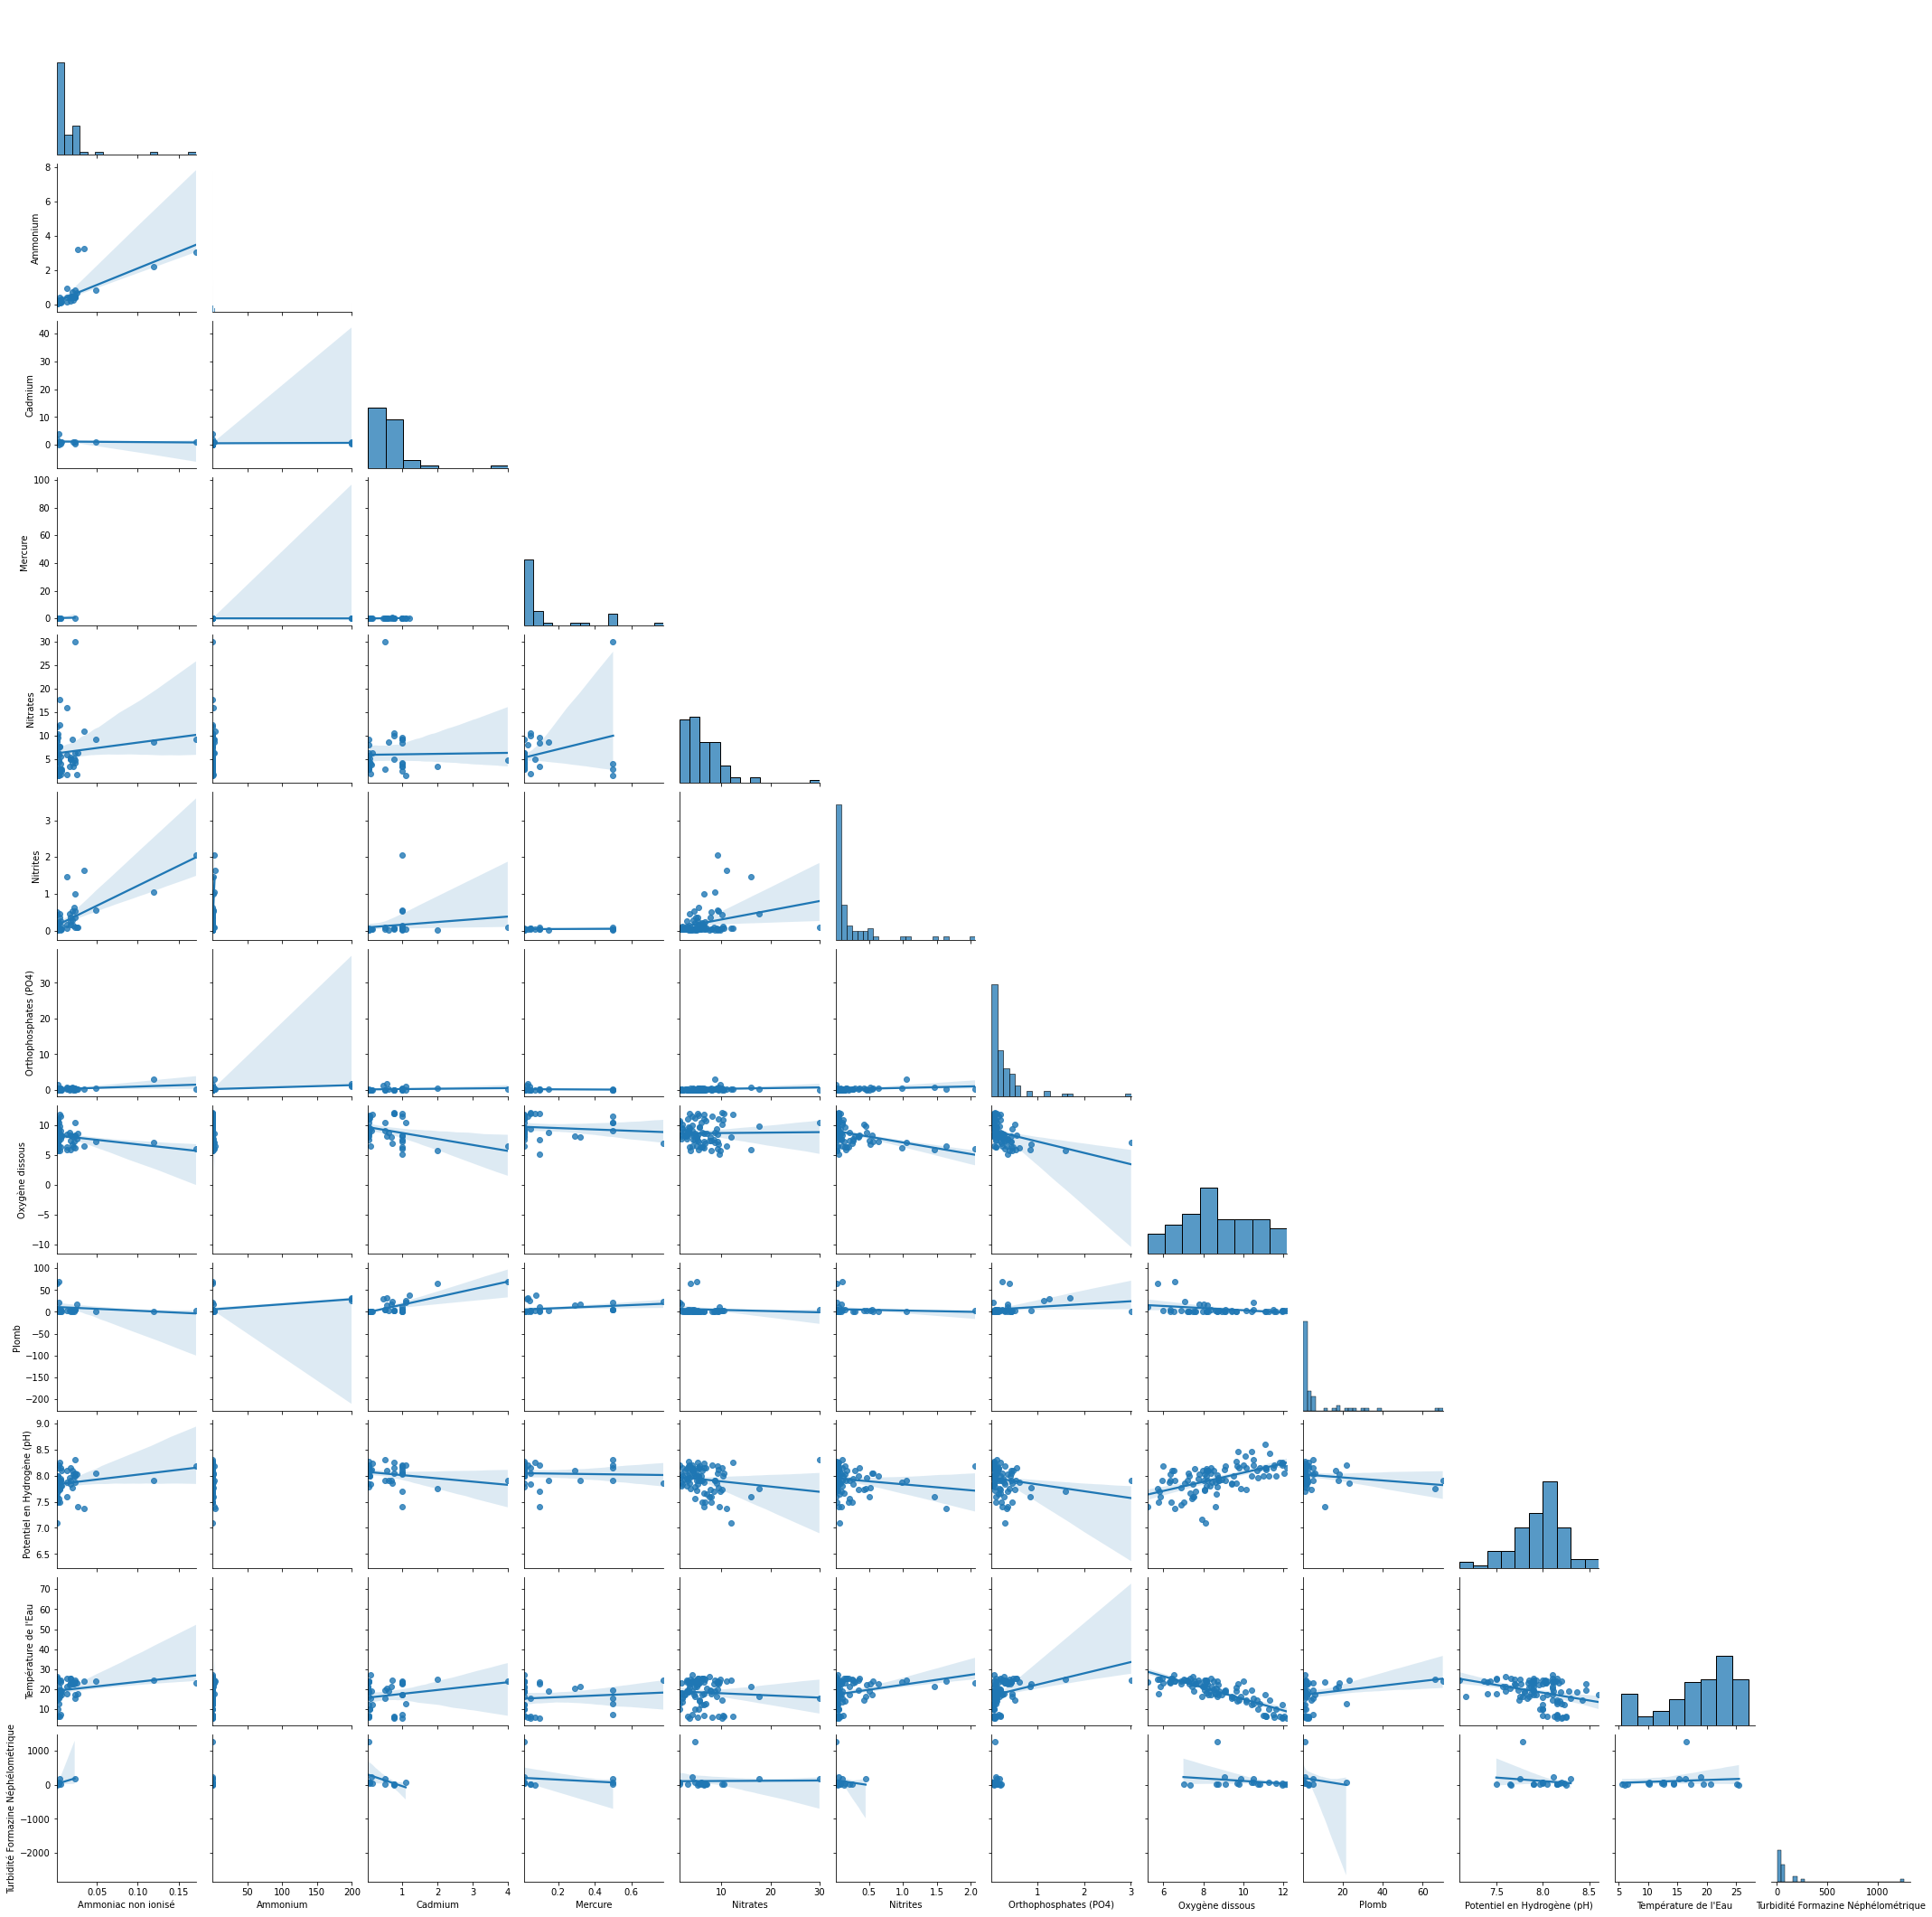

,Ammoniac non ionisé,Ammonium,Cadmium,Mercure,Nitrates,Nitrites,Orthophosphates (PO4),Oxygène dissous,Plomb,Potentiel en Hydrogène (pH),Température de l'Eau,Turbidité Formazine Néphélométrique
Ammoniac non ionisé,1.000000,0.730143,-0.093610,0.425961,0.133952,0.724500,0.459087,-0.267886,-0.184803,0.217196,0.238651,0.665164
Ammonium,0.730143,1.000000,0.054084,-0.120099,0.190629,0.735995,0.476334,-0.310770,0.386733,-0.244372,0.226448,-0.009927
Cadmium,-0.093610,0.054084,1.000000,0.463462,0.016291,0.160195,0.190021,-0.367521,0.766520,-0.248503,0.207486,-0.366198
Mercure,0.425961,-0.120099,0.463462,1.000000,0.303331,0.155897,-0.096718,-0.127478,0.316586,-0.047534,0.115402,-0.167992
Nitrates,0.133952,0.190629,0.016291,0.303331,1.000000,0.287558,0.214437,0.017291,-0.088386,-0.167405,-0.071781,0.015660
Nitrites,0.724500,0.735995,0.160195,0.155897,0.287558,1.000000,0.397821,-0.381837,-0.076950,-0.169151,0.286556,-0.110165
Orthophosphates (PO4),0.459087,0.476334,0.190021,-0.096718,0.214437,0.397821,1.000000,-0.398399,0.224923,-0.207309,0.346108,-0.070782
Oxygène dissous,-0.267886,-0.310770,-0.367521,-0.127478,0.017291,-0.381837,-0.398399,1.000000,-0.336328,0.568805,-0.849747,-0.209974
Plomb,-0.184803,0.386733,0.766520,0.316586,-0.088386,-0.076950,0.224923,-0.336328,1.000000,-0.228248,0.249282,-0.158511
Potentiel en Hydrogène (pH),0.217196,-0.244372,-0.248503,-0.047534,-0.167405,-0.169151,-0.207309,0.568805,-0.228248,1.000000,-0.356494,-0.168732


In [32]:
##Création d'un nouveau dataframe pour ne pas avoir certains champs
df_piv_val = pd.DataFrame()
for x in df_pivot:
    if x[0] == 'valeur':
        df_piv_val[x[1]] = df_pivot[x]
        

sns.pairplot(data=df_piv_val, kind="reg", corner=True)
plt.show()
df_piv_val.corr()

## Observations

Certaines correlations se voient dans notre "pairplot" de "regplot", d'autres ne sont pas si évidentes et nécessitent une analyse mathématiques avec le coefficient de corrélation.

1 - 
L'Oxygène dissous est fortement corrélé avec le pH et avec la température de l'eau. 
Nous savons que ces critères sont en lien avec la vivabilité de l'eau, c'est donc pourquoi nous les étudierons ensemble.

Note: Le pH et l'Oxygène dissous sont liés par l'activité des phytoplanctons (https://www.hydroecologie.org/articles/hydro/pdf/1999/01/hydro99105.pdf)

Ainsi, nous examinerons la qualité de l'eau pour les êtres vivants suite à une inondation. Cette étude sera enrichie grâce à d'autres informations regroupées ailleurs. (Ammoniac et Nitrites cf. 3)

2- 
Le Plomb et le Cadmium sont corrélés, nous savons que ces deux métaux sont utilisés dans la métallurgie ou la création de batterie. Nous les étudierons ensemble et rajouterons le Mercure afin de déterminer si ce dernier est réellement aussi rare dans nos eaux que le laisse entendre l'article sur lequel nous nous sommes basés.
Ainsi, nous vérifierons la véracité de l'information que nous avons eu en plus de chercher à savoir si ces métaux lourds, et la feraille au sens général, sont emportés par ces événements naturels.

3-
L'Ammoniac non ionisé, l'Ammonium et les Nitrites ont un coefficient de corrélation > 0.70. Ces éléments sont les produits de la dégradation de matière organique, nous regrouperons alors ces données ensemble. Bien que les Nitrates n'aient pas de forte corrélation, nous les ajouterons car ces derniers font aussi partie du cycle de la dégradation des matières organiques.
Ainsi, nous testerons si lors des inondations à Toulouse la Garonne se charge en matière organique mais aussi en nitrates présents dans les engrais.

4 - La turbidité, c'est à dire la clarté de l'eau, est mise en corrélation avec la présence d'Ammoniac non ionisé, c'est à dire potentiellement avec des rejets organiques. Nous l'analyserons dans l'objectif de savoir si la Garonne brasse énormément lors de période d'inondations sur la zone Toulousaine.




=============GRAPHIQUES============
=====================================

### METAUX LOURDS

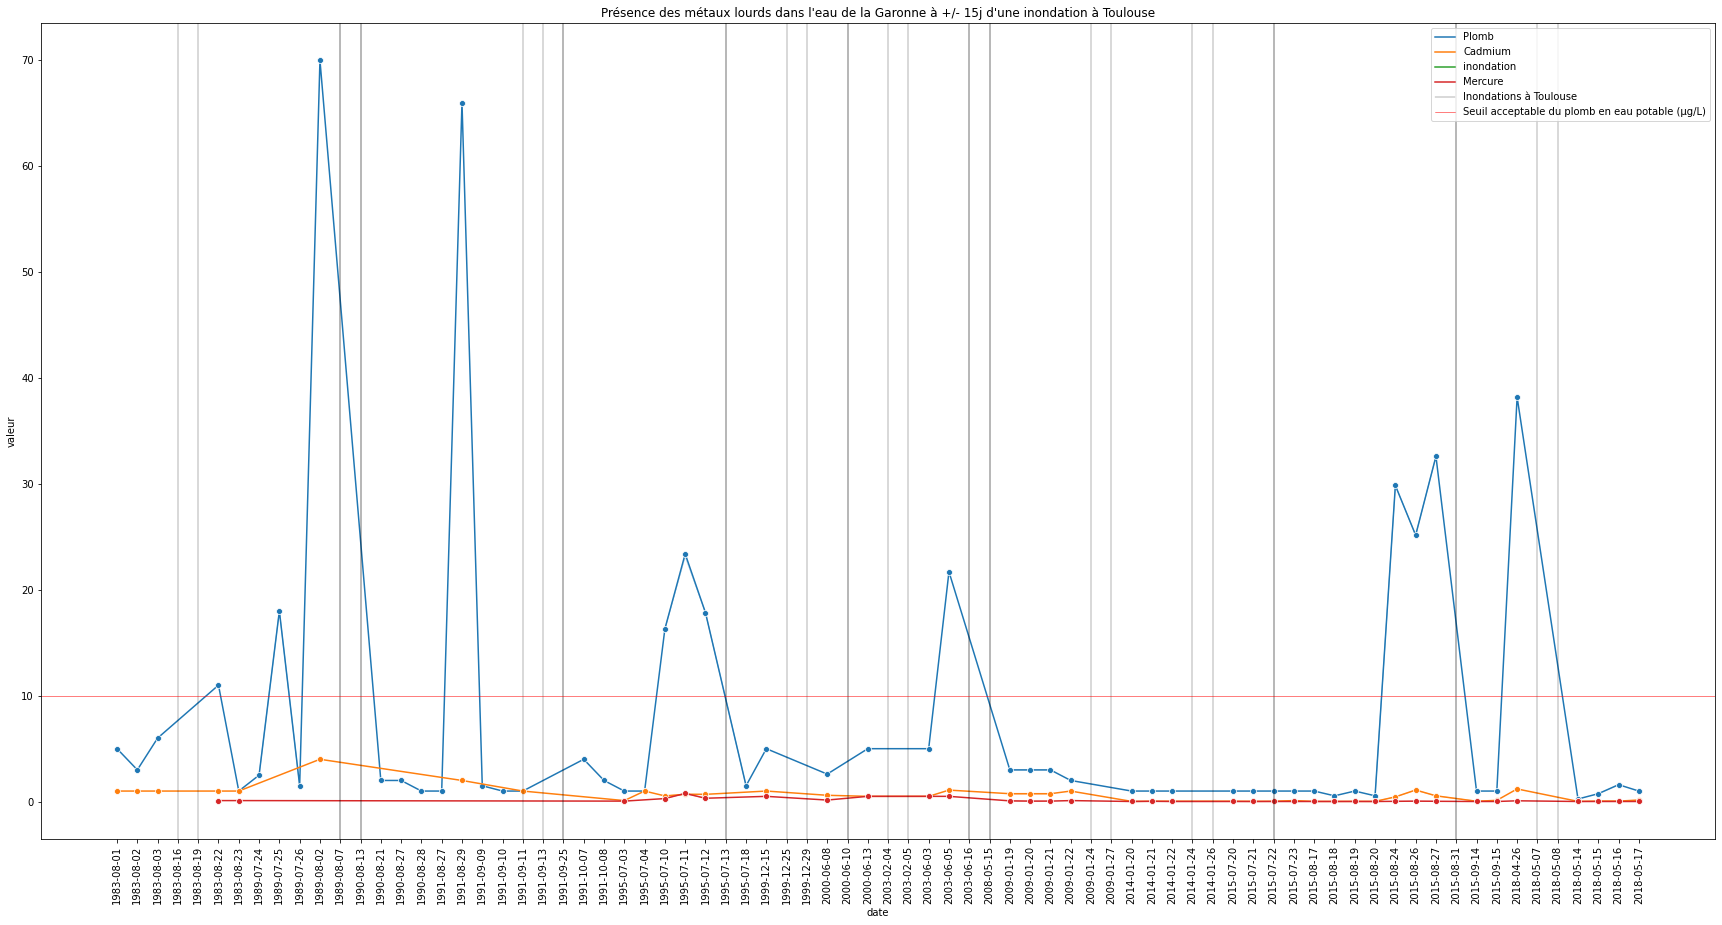

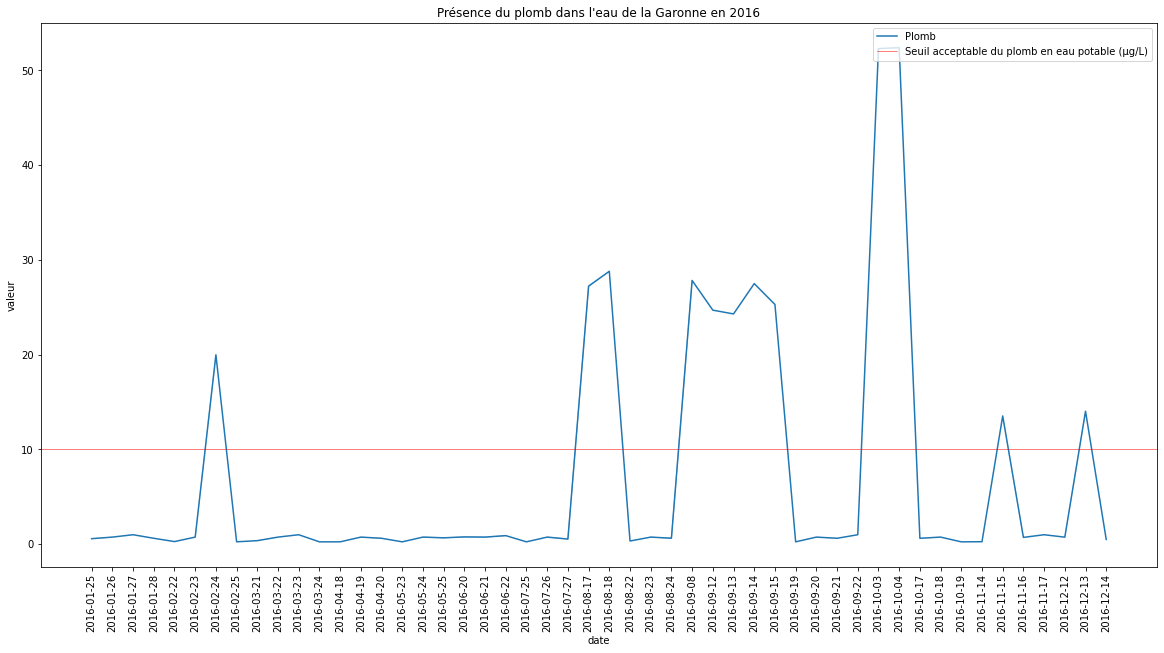

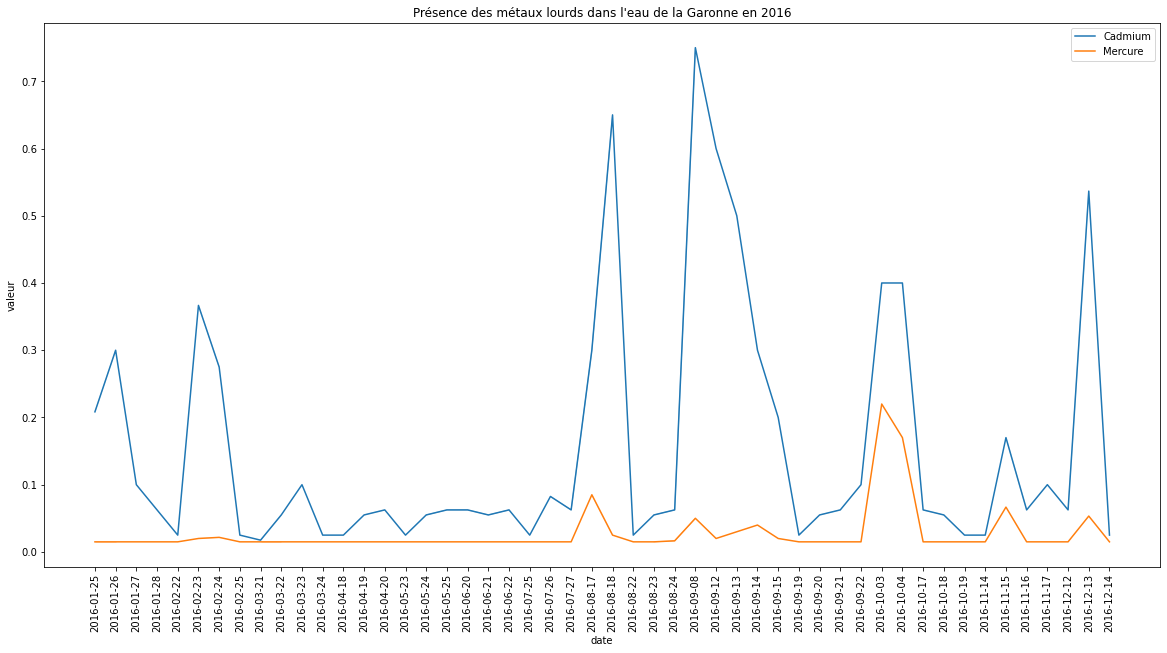

In [11]:
##Graphiques concentration métaux lourds sur la Garonne à 15j avant et après une inondation à Toulouse
plt.figure(figsize=(30, 15)) # Pour changer la taille du plot
df_metaux_lourds = df[df["libelle"].isin(["Mercure","Cadmium","Plomb","inondation"])].sort_values(by="date")
    
sns.lineplot(data=df_metaux_lourds,x=df_metaux_lourds["date"],y=df_metaux_lourds["valeur"],hue="libelle",marker='o',ci=False)

label = True
for d in date_abscisses:
    if label:
        plt.axvline(x=d, color='k', linewidth=0.3, label="Inondations à Toulouse")
        label=False
    else:
        plt.axvline(x=d, color='k', linewidth=0.3)
        
plt.axhline(y=10, color='r', linewidth=0.5, label="Seuil acceptable du plomb en eau potable (µg/L)")

plt.xticks(rotation=90)
plt.title("Présence des métaux lourds dans l'eau de la Garonne à +/- 15j d'une inondation à Toulouse")
plt.legend(loc="upper right")
plt.show()


##Standard 2016 comme comparaison
plt.figure(figsize=(20, 10))
df_std_metaux = df_std[df_std["libelle"].isin(["Plomb"])].sort_values(by="date")
df_std_metaux = df_std_metaux[df_std_metaux["valeur"] <= 100 ]
sns.lineplot(data=df_std_metaux,x=df_std_metaux["date"],y=df_std_metaux["valeur"],hue="libelle",ci=False)
plt.axhline(y=10, color='r', linewidth=0.5, label="Seuil acceptable du plomb en eau potable (µg/L)")
plt.xticks(rotation=90)
plt.title("Présence du plomb dans l'eau de la Garonne en 2016")
plt.legend(loc="upper right")
plt.show()

##Standard 2016 comme comparaison
plt.figure(figsize=(20, 10))
df_std_metaux = df_std[df_std["libelle"].isin(["Cadmium","Mercure"])].sort_values(by="date")
sns.lineplot(data=df_std_metaux,x=df_std_metaux["date"],y=df_std_metaux["valeur"],hue="libelle",ci=False)
plt.xticks(rotation=90)
plt.title("Présence des métaux lourds dans l'eau de la Garonne en 2016")
plt.legend(loc="upper right")
plt.show()

### TRACE D'AZOTE

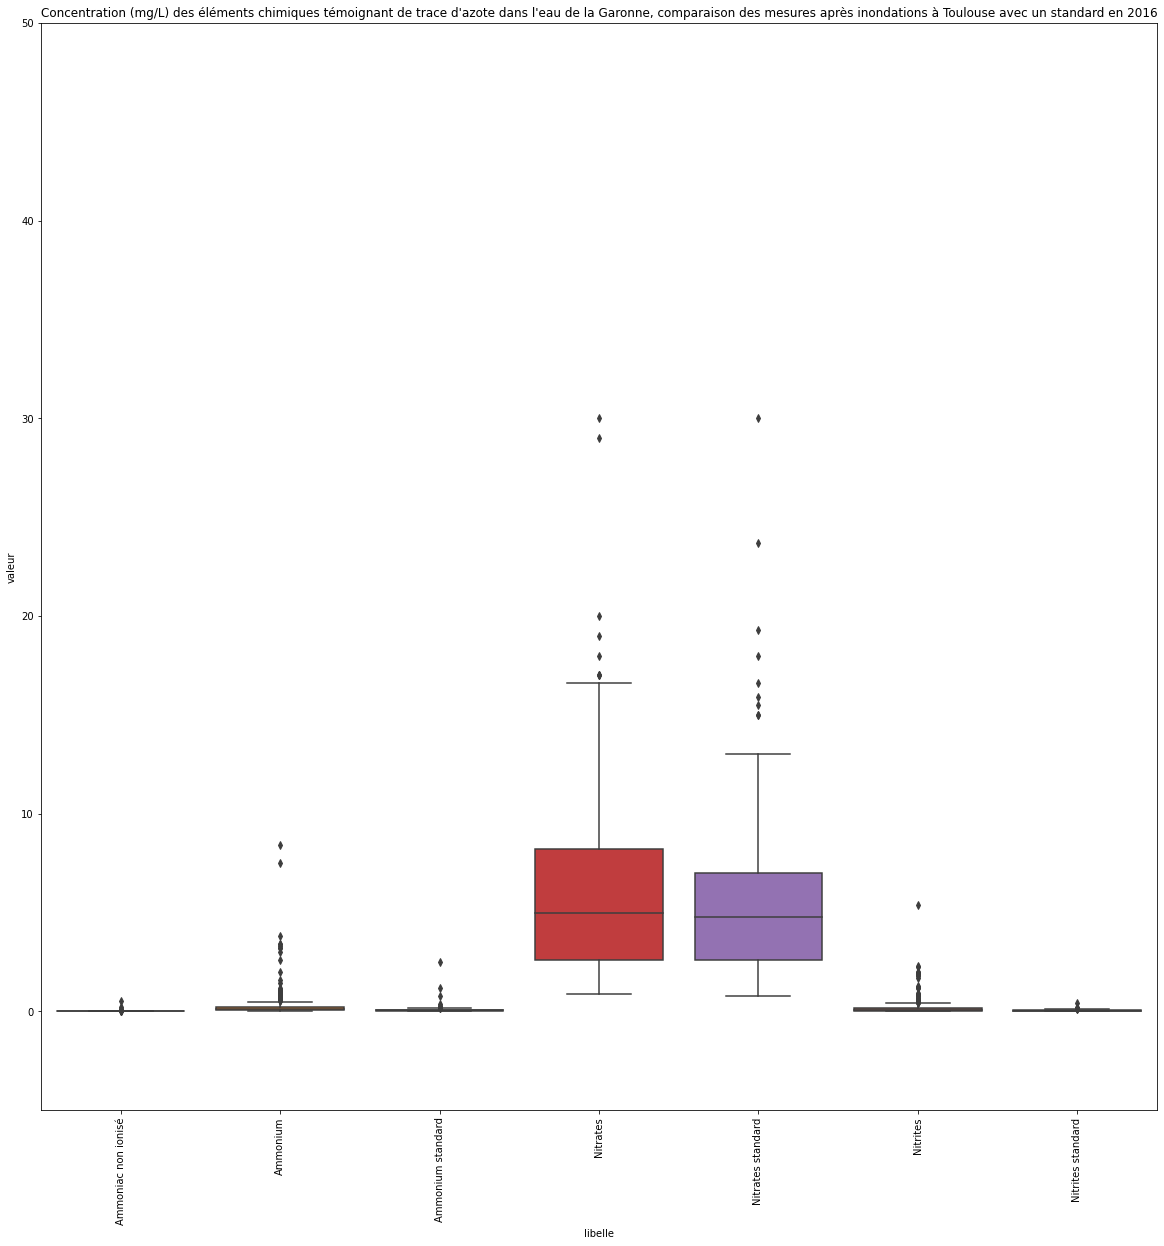

In [12]:
plt.figure(figsize=(20, 20)) # Pour changer la taille du plot
df_organiques = df[df["libelle"].isin(["Ammonium","Nitrates","Nitrites","Ammoniac non ionisé"])].sort_values(by="date")
df_std_organiques = df_std[df_std["libelle"].isin(["Ammonium","Nitrates","Nitrites","Ammoniac non ionisé"])].sort_values(by="date").copy()

df_organiques_fus = df_organiques.copy()
##Ammoniac n'est plus mesuré à partir d'une certaine année
df_std_organiques = df_std_organiques.copy().replace({"libelle": {"Ammonium":"Ammonium standard","Nitrates":"Nitrates standard",
                                      "Nitrites":"Nitrites standard"}})
df_organiques_fus = pd.concat([df_organiques_fus,df_std_organiques]).sort_values(by="libelle")

visuel = sns.boxplot(data=df_organiques_fus,x=df_organiques_fus["libelle"],y=df_organiques_fus["valeur"])
#visuel2 = sns.boxplot(data=df_std_organiques,x=df_std_organiques["libelle"],y=df_std_organiques["valeur"])
visuel.set(ylim=(-5, 50))
plt.xticks(rotation=90)
plt.title("Concentration (mg/L) des éléments chimiques témoignant de trace d'azote dans l'eau de la Garonne, comparaison des mesures après inondations à Toulouse avec un standard en 2016")
#plt.legend()
plt.show()


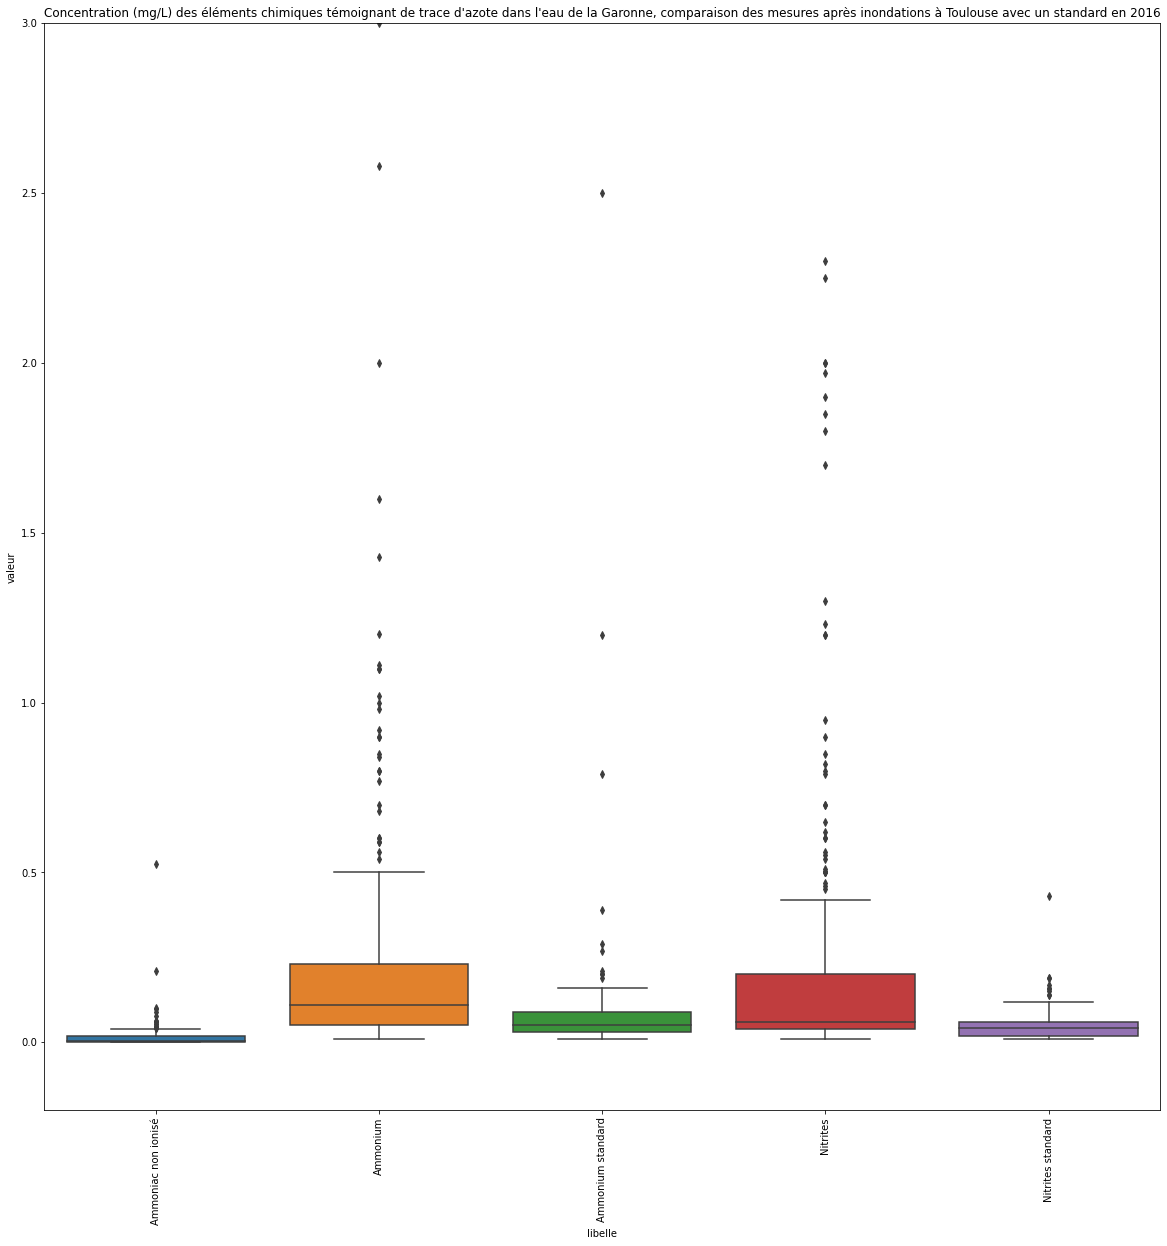

In [13]:
plt.figure(figsize=(20, 20)) # Pour changer la taille du plot
df_organiques = df[df["libelle"].isin(["Ammonium","Nitrites","Ammoniac non ionisé"])].sort_values(by="date")
df_std_organiques = df_std[df_std["libelle"].isin(["Ammonium","Nitrites","Ammoniac non ionisé"])].sort_values(by="date").copy()

df_organiques_fus = df_organiques.copy()
##Ammoniac n'est plus mesuré à partir d'une certaine année
df_std_organiques = df_std_organiques.copy().replace({"libelle": {"Ammonium":"Ammonium standard",
                                      "Nitrites":"Nitrites standard"}})
df_organiques_fus = pd.concat([df_organiques_fus,df_std_organiques]).sort_values(by="libelle")

visuel = sns.boxplot(data=df_organiques_fus,x=df_organiques_fus["libelle"],y=df_organiques_fus["valeur"])
#visuel2 = sns.boxplot(data=df_std_organiques,x=df_std_organiques["libelle"],y=df_std_organiques["valeur"])
visuel.set(ylim=(-0.2, 3))
plt.xticks(rotation=90)
plt.title("Concentration (mg/L) des éléments chimiques témoignant de trace d'azote dans l'eau de la Garonne, comparaison des mesures après inondations à Toulouse avec un standard en 2016")
#plt.legend()
plt.show()


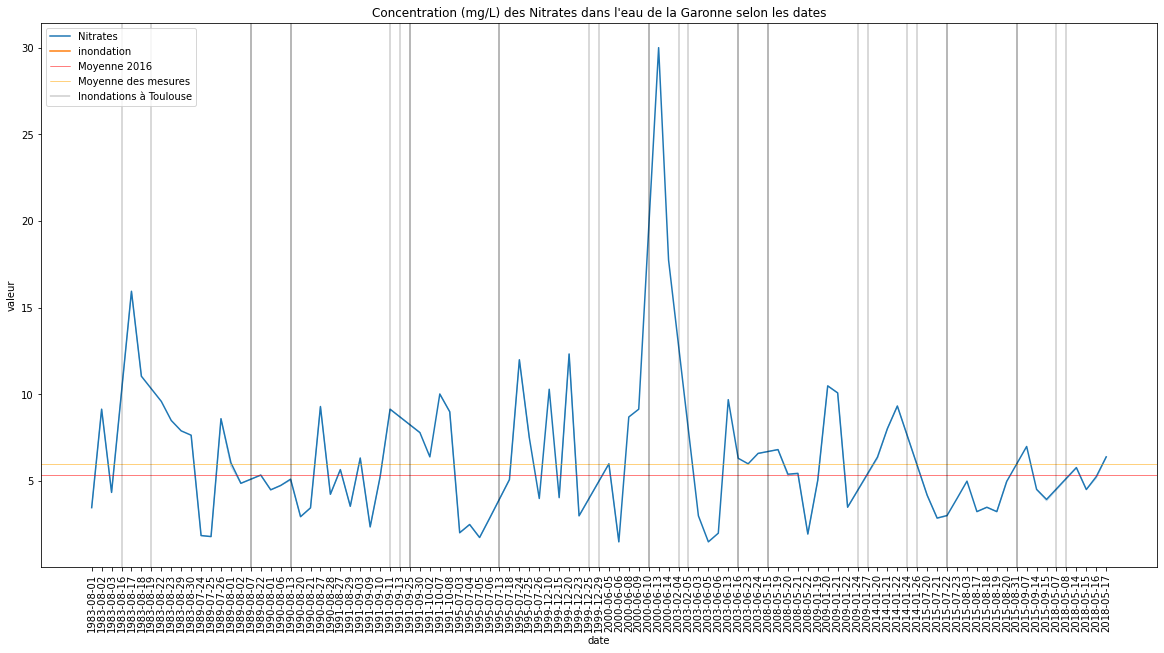

In [14]:
df_nitrates = df[df["libelle"].isin(["Nitrates","inondation"])].sort_values(by="date")

##PREMIER GRAPH

nitrates_mean_16 = df_std[df_std["libelle"]=="Nitrates"].mean()

nitrates_mean_inondations = df_nitrates.mean()

plt.figure(figsize=(20, 10)) # Pour changer la taille du plot
visuel = sns.lineplot(data=df_nitrates,x=df_nitrates["date"],y=df_nitrates["valeur"],hue="libelle",ci=False)
plt.axhline(y=nitrates_mean_16[0], color='r', linewidth=0.5, label="Moyenne 2016")
plt.axhline(y=nitrates_mean_inondations[0], color='orange', linewidth=0.5, label="Moyenne des mesures")

label = True
for d in date_abscisses:
    if label:
        plt.axvline(x=d, color='k', linewidth=0.3, label="Inondations à Toulouse")
        label=False
    else:
        plt.axvline(x=d, color='k', linewidth=0.3)

plt.xticks(rotation=90)
plt.title("Concentration (mg/L) des Nitrates dans l'eau de la Garonne selon les dates")
plt.legend()
plt.show()

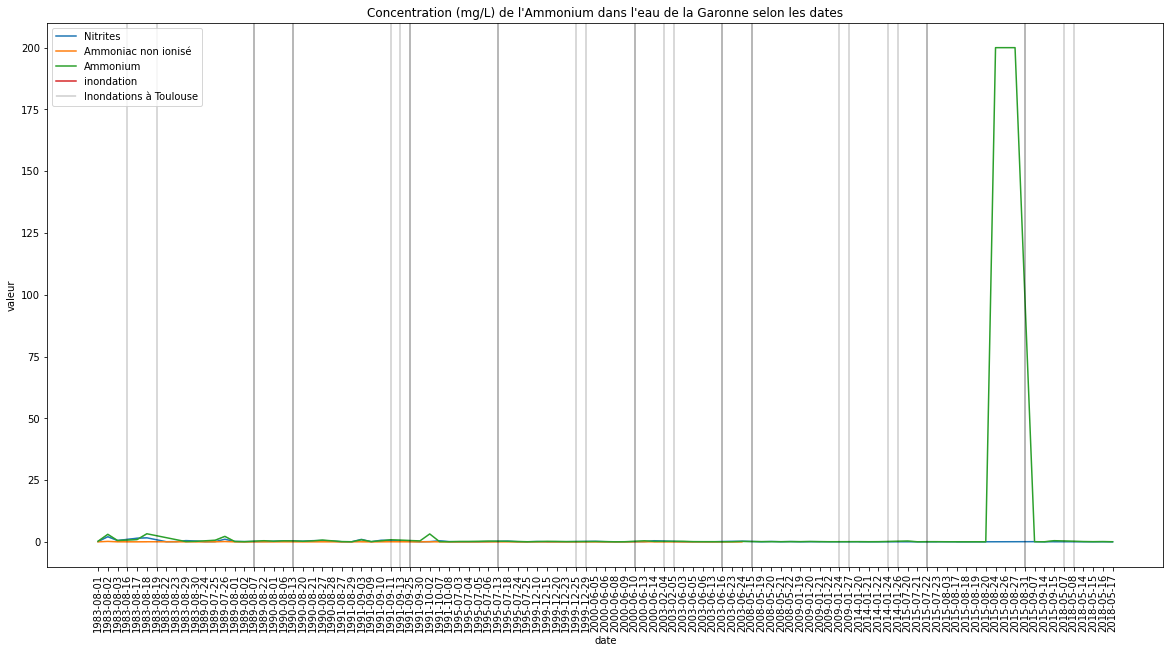

In [15]:
df_azote = df[df["libelle"].isin(["Ammonium","Nitrites","Ammoniac non ionisé","inondation"])].sort_values(by="date")


##PREMIER GRAPH AUTRES
plt.figure(figsize=(20, 10)) # Pour changer la taille du plot
visuel = sns.lineplot(data=df_azote,x=df_azote["date"],y=df_azote["valeur"],hue="libelle",ci=False)
label = True
for d in date_abscisses:
    if label:
        plt.axvline(x=d, color='k', linewidth=0.3, label="Inondations à Toulouse")
        label=False
    else:
        plt.axvline(x=d, color='k', linewidth=0.3)
plt.xticks(rotation=90)
plt.title("Concentration (mg/L) de l'Ammonium dans l'eau de la Garonne selon les dates")
plt.legend()
plt.show()


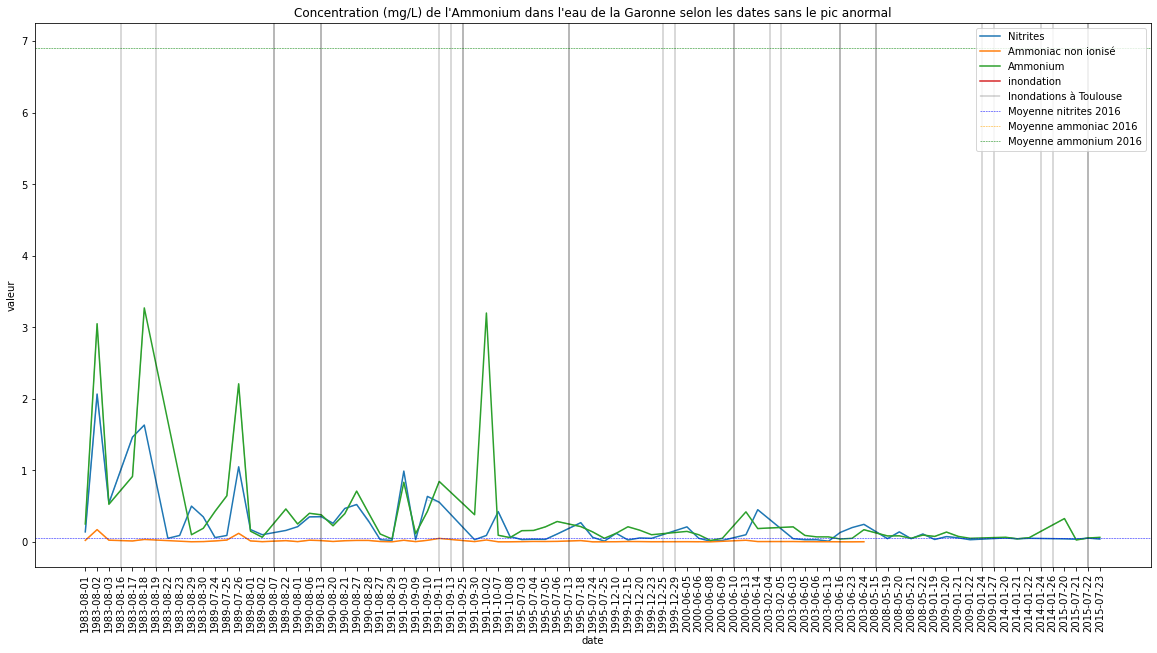

In [16]:
###DEUXIEME GRAPH AUTRE

plt.figure(figsize=(20, 10)) # Pour changer la taille du plot
df_azote = df_azote[df_azote["date"]<"2015-08-01"]
visuel2 = sns.lineplot(data=df_azote,x=df_azote["date"],y=df_azote["valeur"],hue="libelle",ci=False)

#Ajout des inondations
label = True
for d in date_abscisses:
    if d < "2015-08-01":
        if label:
            plt.axvline(x=d, color='k', linewidth=0.3, label="Inondations à Toulouse")
            label=False
        else:
            plt.axvline(x=d, color='k', linewidth=0.3)
            
#Tracé des moyennes sur l'année 2016 pour comparaison
nitrites_mean_16 = df_std[df_std["libelle"]=="Nitrites"].mean()
plt.axhline(y=nitrites_mean_16[0], color='b', linestyle='--', linewidth=0.5, label="Moyenne nitrites 2016")

ammoniac_mean_16 = df_std[df_std["libelle"]=="Ammoniac non ionisé"].mean()
plt.axhline(y=ammoniac_mean_16[0], color='orange', linestyle='--', linewidth=0.5, label="Moyenne ammoniac 2016")

ammonium_mean_16 = df_std[df_std["libelle"]=="Ammonium"].mean()
plt.axhline(y=ammonium_mean_16[0], color='g', linestyle='--', linewidth=0.5, label="Moyenne ammonium 2016")

plt.xticks(rotation=90)
plt.title("Concentration (mg/L) de l'Ammonium dans l'eau de la Garonne selon les dates sans le pic anormal")
plt.legend(loc="upper right")
plt.show()

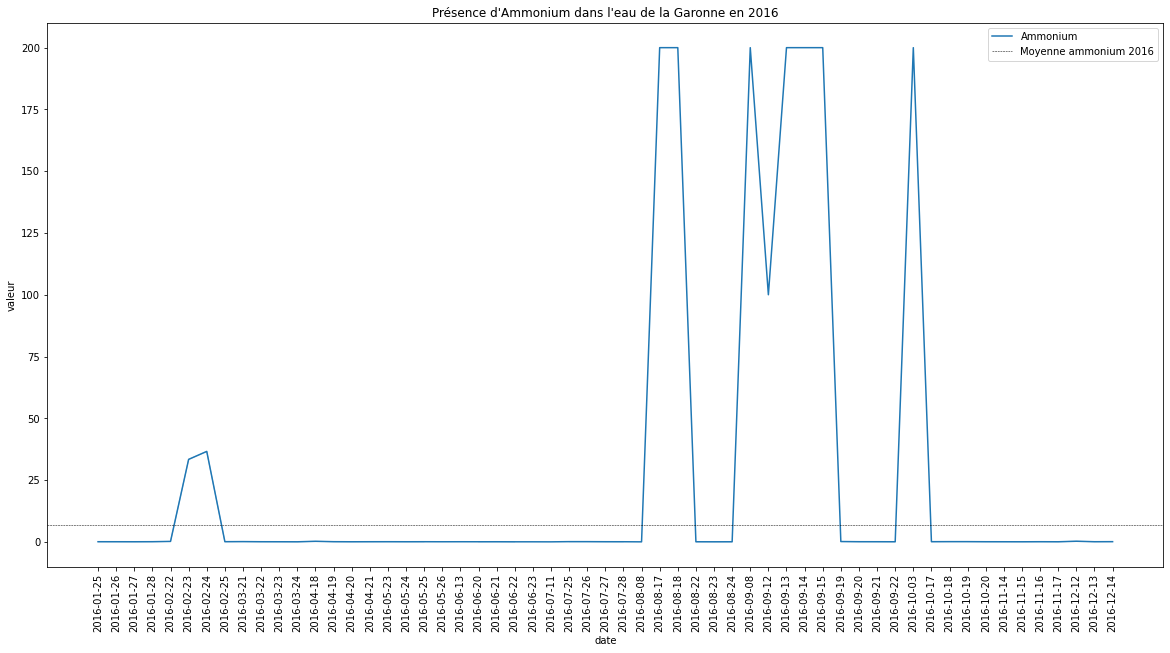

In [17]:
##Standard 2016 comme comparaison
plt.figure(figsize=(20, 10))
df_std_metaux = df_std[df_std["libelle"].isin(["Ammonium"])].sort_values(by="date")
sns.lineplot(data=df_std_metaux,x=df_std_metaux["date"],y=df_std_metaux["valeur"],hue="libelle",ci=False)
plt.axhline(y=ammonium_mean_16[0], color='k', linestyle='--', linewidth=0.5, label="Moyenne ammonium 2016")
plt.xticks(rotation=90)
plt.title("Présence d'Ammonium dans l'eau de la Garonne en 2016")
plt.legend(loc="upper right")
plt.show()

### Qualité de vivabilité de la faune / flore marine

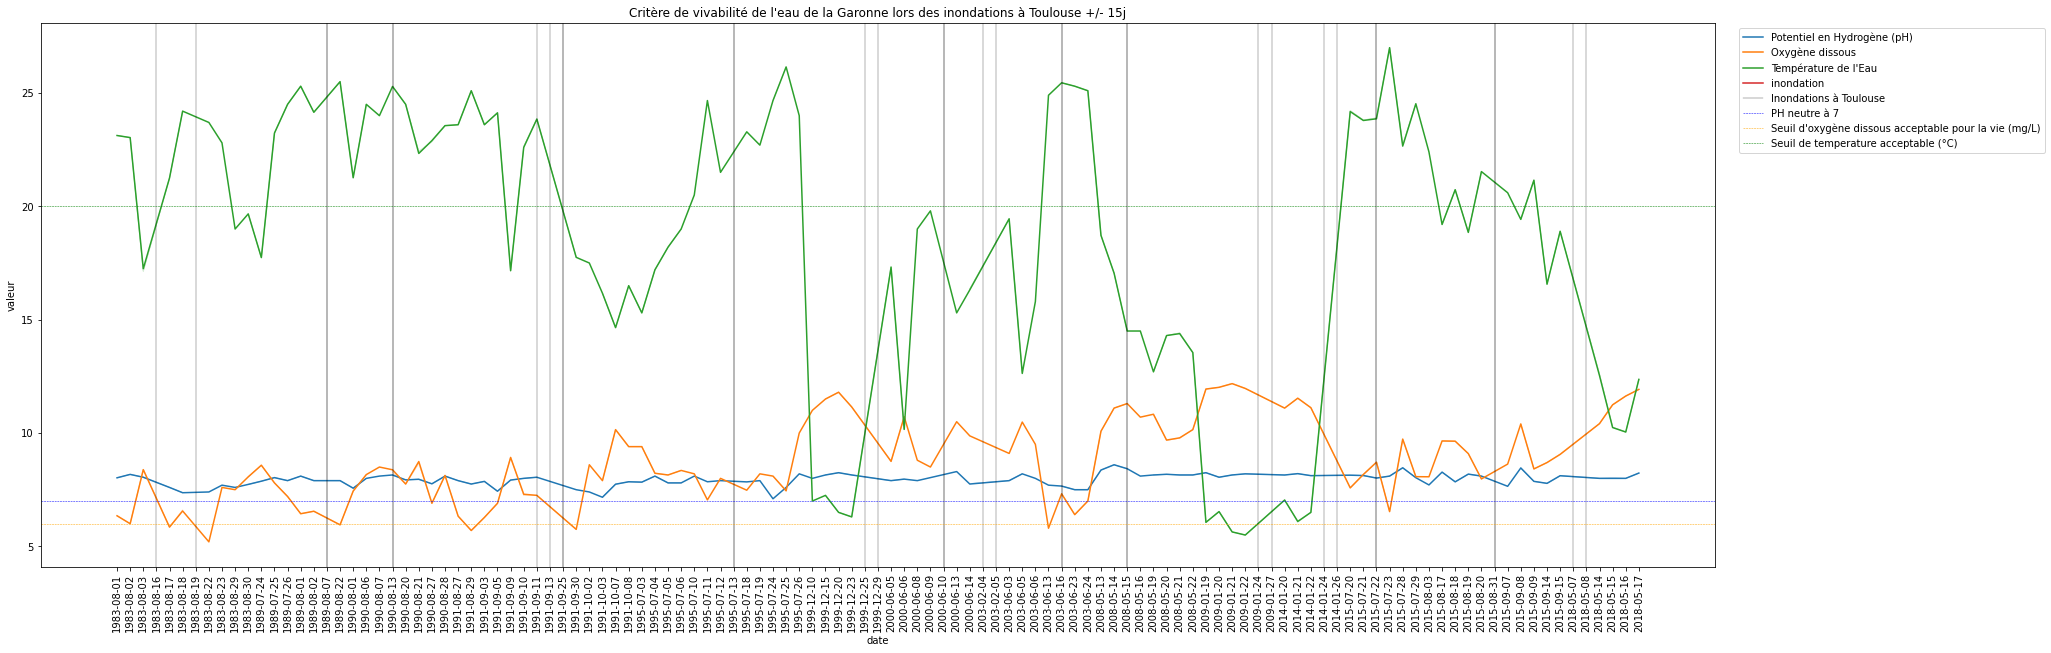

In [25]:
df_vivabilite = df[df["libelle"].isin(["Oxygène dissous","Température de l'Eau","Potentiel en Hydrogène (pH)","inondation"])]

plt.figure(figsize=(30, 10)) # Pour changer la taille du plot
visuel2 = sns.lineplot(data=df_vivabilite,x=df_vivabilite["date"],y=df_vivabilite["valeur"],hue="libelle",ci=False)
#Ajout des inondations
label = True
for d in date_abscisses:
    if label:
        plt.axvline(x=d, color='k', linewidth=0.3, label="Inondations à Toulouse")
        label=False
    else:
        plt.axvline(x=d, color='k', linewidth=0.3)

plt.xticks(rotation=90)
plt.axhline(y=7, color='b', linestyle='--', linewidth=0.5, label="PH neutre à 7")
plt.axhline(y=6, color='orange', linestyle='--', linewidth=0.5, label="Seuil d'oxygène dissous acceptable pour la vie (mg/L)")
plt.axhline(y=20, color='g', linestyle='--', linewidth=0.5, label="Seuil de temperature acceptable (°C)")
plt.title("Critère de vivabilité de l'eau de la Garonne lors des inondations à Toulouse +/- 15j")
plt.legend(loc="upper right",bbox_to_anchor=(1.2, 1))
plt.show()

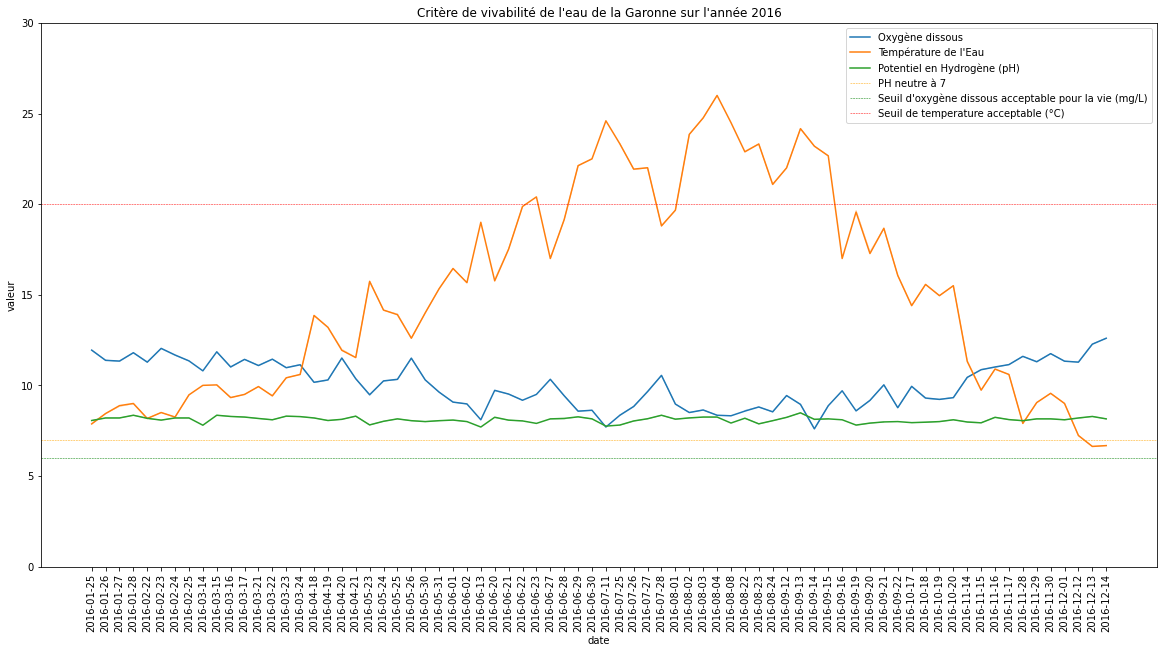

In [19]:
df_std_vivabilite = df_std[
    df_std["libelle"].isin(["Oxygène dissous","Température de l'Eau","Potentiel en Hydrogène (pH)","inondation"])
]

plt.figure(figsize=(20, 10)) # Pour changer la taille du plot
sns.lineplot(data=df_std_vivabilite,x=df_std_vivabilite["date"],y=df_std_vivabilite["valeur"],hue="libelle",ci=False)
plt.ylim(0,30)
plt.xticks(rotation=90)
plt.axhline(y=7, color='orange', linestyle='--', linewidth=0.5, label="PH neutre à 7")
plt.axhline(y=6, color='g', linestyle='--', linewidth=0.5, label="Seuil d'oxygène dissous acceptable pour la vie (mg/L)")
plt.axhline(y=20, color='r', linestyle='--', linewidth=0.5, label="Seuil de temperature acceptable (°C)")
plt.title("Critère de vivabilité de l'eau de la Garonne sur l'année 2016")
plt.legend(loc="upper right")
plt.show()

### Turbidité

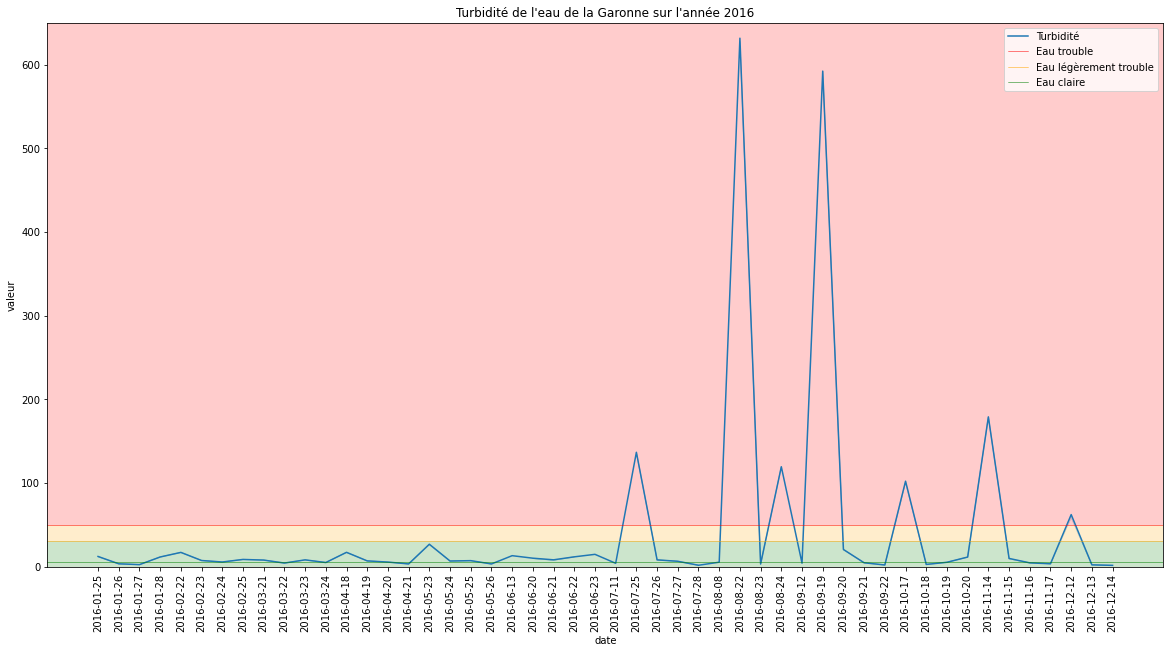

,date,libelle,valeur,unite
0,2016-01-25,Orthophosphates (PO4),0.0800,mg(PO4)/L
679,2016-01-25,Nitrites,0.0690,mg(NO2)/L
680,2016-01-25,Turbidité Formazine Néphélométrique,52.0000,NFU
681,2016-01-25,Oxygène dissous,11.4000,mg(O2)/L
682,2016-01-25,Plomb,0.2500,µg(Pb)/L
...,...,...,...,...
918,2016-12-14,Oxygène dissous,12.9000,mg(O2)/L
919,2016-12-14,Ammonium,0.0616,mg(NH4)/L
921,2016-12-14,Nitrites,0.0404,mg(NO2)/L
923,2016-12-14,Orthophosphates (PO4),0.0850,mg/L


In [20]:
df_std_turbidite = df_std[
    df_std["libelle"].isin(["Turbidité Formazine Néphélométrique","inondation"])
]

plt.figure(figsize=(20, 10)) # Pour changer la taille du plot
sns.lineplot(data=df_std_turbidite,x=df_std_turbidite["date"],y=df_std_turbidite["valeur"]
             ,label="Turbidité", ci=False)
plt.xticks(rotation=90)
plt.ylim(0,650)
plt.axhline(y=50, color='r', linewidth=0.5, label="Eau trouble")
plt.axhspan(50, 650, facecolor='r', alpha=0.2)
plt.axhline(y=30, color='orange', linewidth=0.5, label="Eau légèrement trouble")
plt.axhspan(30,50, facecolor='orange', alpha=0.2)
plt.axhline(y=5, color='g', linewidth=0.5, label="Eau claire")
plt.axhspan(0,30, facecolor='g', alpha=0.2)
plt.title("Turbidité de l'eau de la Garonne sur l'année 2016")
plt.legend(loc="upper right")
plt.show()

df_std

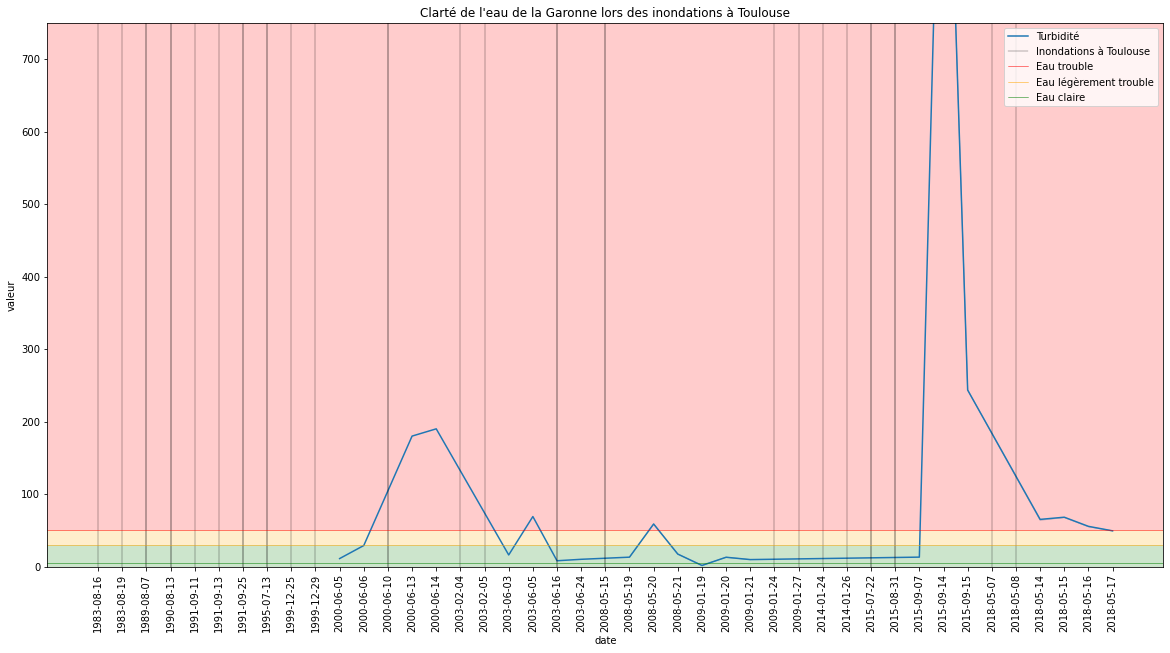

In [26]:
df_turbidite = df[
    df["libelle"].isin(["Turbidité Formazine Néphélométrique","inondation"])
]

plt.figure(figsize=(20, 10)) # Pour changer la taille du plot
sns.lineplot(data=df_turbidite,x=df_turbidite["date"],y=df_turbidite["valeur"]
             ,label="Turbidité", ci=False)


#Ajout des inondations
label = True
for d in date_abscisses:
    if label:
        plt.axvline(x=d, color='k', linewidth=0.3, label="Inondations à Toulouse")
        label=False
    else:
        plt.axvline(x=d, color='k', linewidth=0.3)
            
plt.xticks(rotation=90)
plt.ylim(0,750)
plt.axhline(y=50, color='r', linewidth=0.5, label="Eau trouble")
plt.axhspan(50, 750, facecolor='r', alpha=0.2)
plt.axhline(y=30, color='orange', linewidth=0.5, label="Eau légèrement trouble")
plt.axhspan(30,50, facecolor='orange', alpha=0.2)
plt.axhline(y=5, color='g', linewidth=0.5, label="Eau claire")
plt.axhspan(0,30, facecolor='g', alpha=0.2)
plt.title("Clarté de l'eau de la Garonne lors des inondations à Toulouse")
plt.legend(loc="upper right")
plt.show()

#                                         =====ANALYSE GLOBALE=====
##                                                  ====SERIES TEMPORELLES====

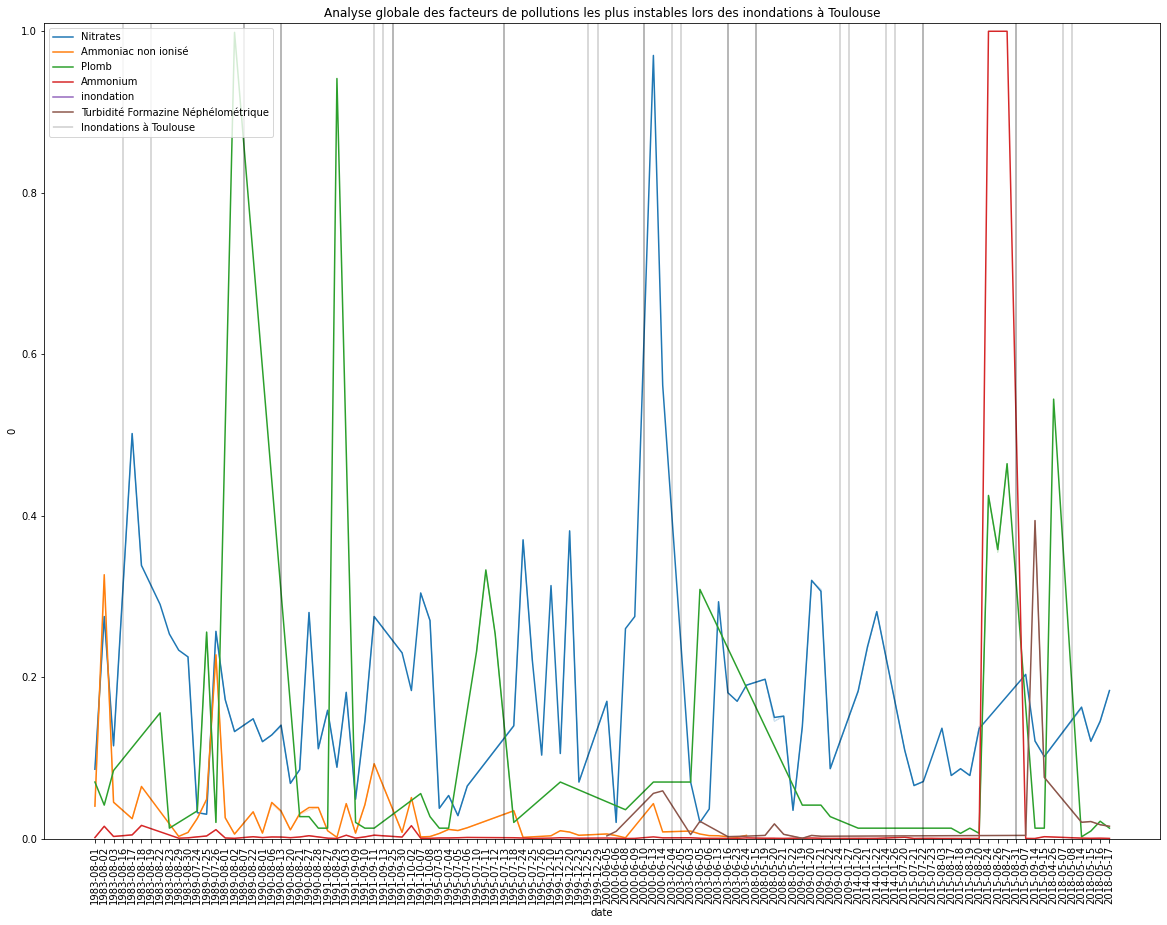

In [22]:
df_globale = df[df["libelle"].isin(["Plomb","Nitrates","Ammonium","Ammoniac non ionisé",
                                    "Turbidité Formazine Néphélométrique","inondation"])].copy().sort_values(by="date")

#Reformatage des catégories
df_globale = df_globale.replace({"libelle": {"Plomb":1,"Nitrates":2,"Ammonium":3,"Ammoniac non ionisé":4,
                                "Turbidité Formazine Néphélométrique":5, "inondation":6}})

##Récupération des min/max pour CHAQUE catégorie sauf inondation
filtres = [1,2,3,4,5]
min_max = []
for filtre in filtres:
    min_max.append([df_globale[df_globale["libelle"]==filtre]["valeur"].min(),
                   df_globale[df_globale["libelle"]==filtre]["valeur"].max()])

##Normalisation Min Max des valeurs par chaque catégorie
df_neutre = pd.DataFrame()
for filtre in filtres:
    new = (df_globale[df_globale["libelle"]==filtre]["valeur"] - min_max[filtre-1][0]) / min_max[filtre-1][1]
    df_neutre = pd.concat([df_neutre,new])

#Ajout des dates et libellés
df_neutre = pd.concat([df_globale["date"],df_neutre],axis=1)
df_neutre = pd.concat([df_globale["libelle"].sort_index(),df_neutre],axis=1)
df_neutre = df_neutre.sort_values(by="date")
df_neutre = df_neutre.replace({"libelle": {1:"Plomb",2:"Nitrates",3:"Ammonium",4:"Ammoniac non ionisé",
                                5:"Turbidité Formazine Néphélométrique", 6:"inondation"}})

plt.figure(figsize=(20,15))
plt.ylim(0,1.01)
sns.lineplot(data=df_neutre, x=df_neutre["date"],y=df_neutre[0],hue=df_neutre["libelle"],ci=False)

#Ajout des inondations
label = True
for d in date_abscisses:
    if label:
        plt.axvline(x=d, color='k', linewidth=0.3, label="Inondations à Toulouse")
        label=False
    else:
        plt.axvline(x=d, color='k', linewidth=0.3)
        
plt.xticks(rotation=90)
plt.title("Analyse globale des facteurs de pollutions les plus instables lors des inondations à Toulouse")
plt.legend()
plt.show()

### Interprétation des résultats

En début Février de l'année 2016, la Garonne est entrée en crue à Bordeaux. Le premier pic est en lien.

https://www.francebleu.fr/infos/climat-environnement/en-images-la-garonne-deborde-bordeaux-1455264700

"Saison des pluies et orages" sur la fin d'été

http://www.lot-et-garonne.gouv.fr/communique-de-presse-vigilance-orange-pour-orages-a7411.html

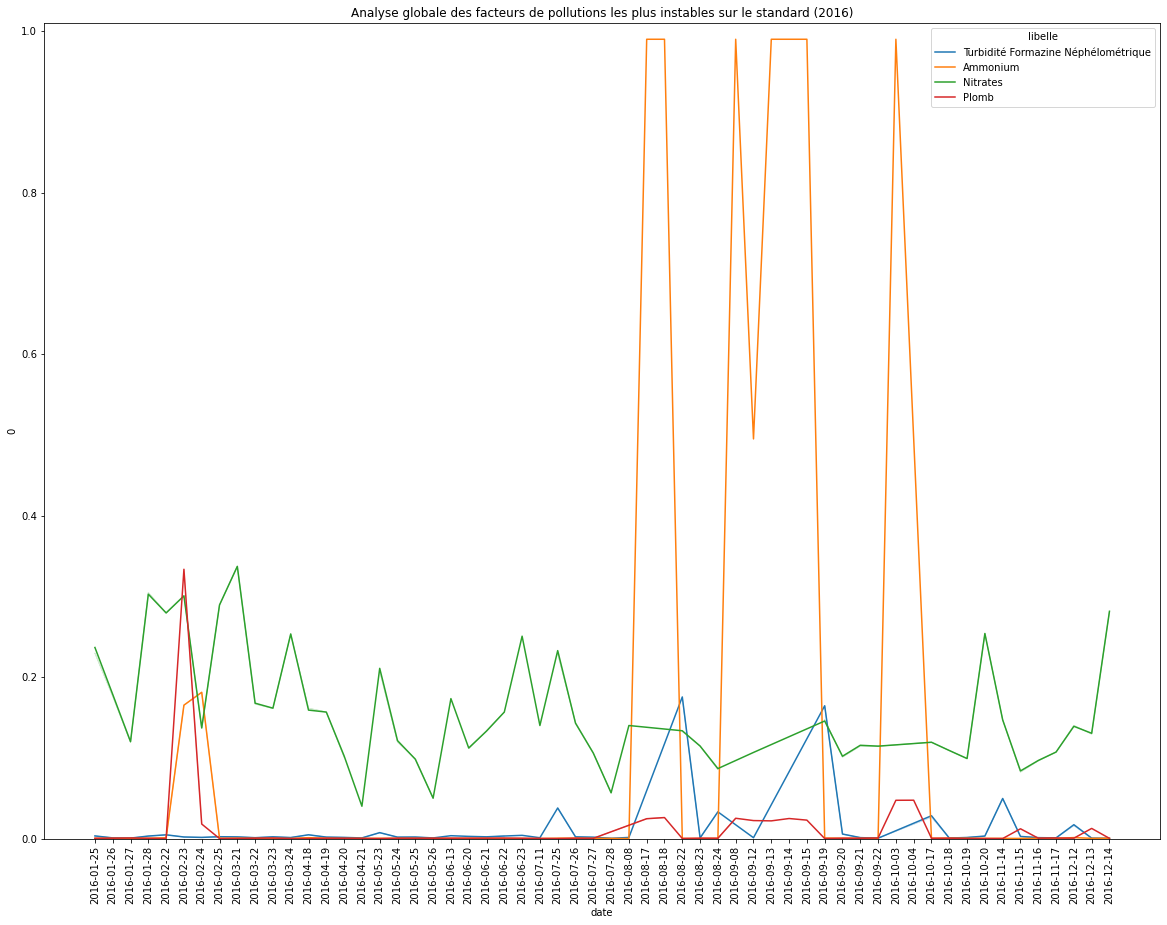

In [27]:
df_std_globale = df_std[df_std["libelle"].isin(["Plomb","Nitrates","Ammonium","Ammoniac non ionisé",
                                    "Turbidité Formazine Néphélométrique"])].copy().sort_values(by="date")

#Reformatage des catégories
df_std_globale = df_std_globale.replace({"libelle": {"Plomb":1,"Nitrates":2,"Ammonium":3,"Ammoniac non ionisé":4,
                                "Turbidité Formazine Néphélométrique":5}})

##Récupération des min/max pour CHAQUE catégorie sauf inondation
filtres = [1,2,3,4,5]
min_max = []
for filtre in filtres:
    min_max.append([df_std_globale[df_std_globale["libelle"]==filtre]["valeur"].min(),
                   df_std_globale[df_std_globale["libelle"]==filtre]["valeur"].max()])

##Normalisation Min Max des valeurs par chaque catégorie
df_std_norm = pd.DataFrame()
for filtre in filtres:
    new = (df_std_globale[df_std_globale["libelle"]==filtre]["valeur"] - min_max[filtre-1][0]) / min_max[filtre-1][1]
    df_std_norm = pd.concat([df_std_norm,new])

#Ajout des dates et libellés
df_std_norm = pd.concat([df_std_globale["date"],df_std_norm],axis=1)
df_std_norm = pd.concat([df_std_globale["libelle"].sort_index(),df_std_norm],axis=1)
df_std_norm = df_std_norm.sort_values(by="date")
df_std_norm = df_std_norm.replace({"libelle": {1:"Plomb",2:"Nitrates",3:"Ammonium",4:"Ammoniac non ionisé",
                                5:"Turbidité Formazine Néphélométrique"}})

plt.figure(figsize=(20,15))
plt.ylim(0,1.01)
sns.lineplot(data=df_std_norm, x=df_std_norm["date"],y=df_std_norm[0],hue=df_std_norm["libelle"],ci=False)
        
plt.xticks(rotation=90)
plt.title("Analyse globale des facteurs de pollutions les plus instables sur le standard (2016)")
plt.show()

##                                                  ====BAR PLOT====
###                                                          Comparaison de la composition 

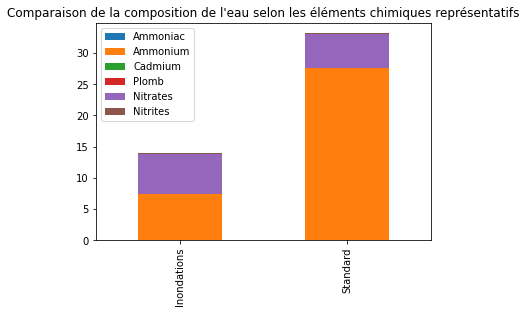

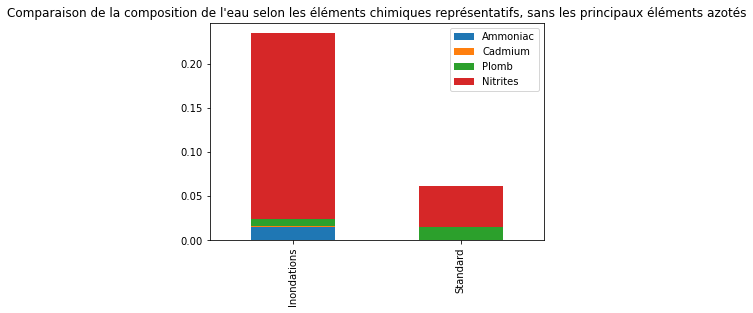

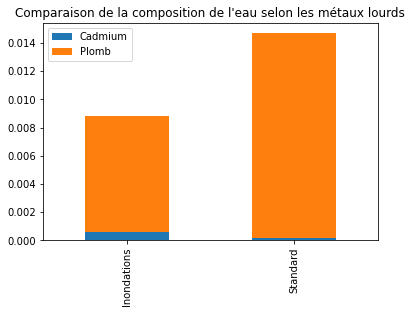

        libelle            
valeur  Ammoniac non ionisé    0.015279
        Ammonium               7.462698
        Cadmium                0.607050
        Plomb                  8.224605
        Nitrates               6.257645
        Nitrites               0.210336
dtype: float64 0.0006070503875968993 0.008224604848484852
        libelle 
valeur  Ammonium    27.598747
        Cadmium      0.156083
        Plomb       14.534827
        Nitrates     5.499497
        Nitrites     0.046943
dtype: float64 0.00015608333333333335 0.014534826666666664


In [28]:
###Récupérer les données voulues sur la composition inondations
###Tout passer en mg
pivot_df = df_pivot[[("valeur","Ammoniac non ionisé"),("valeur","Ammonium"),
                      ("valeur","Cadmium"),("valeur","Plomb"),("valeur","Nitrates"),("valeur","Nitrites")]]

mean = pivot_df.mean()
mean[2] /= 1000
mean[3] /= 1000

###Récupérer les données voulues sur le standard (Ammoniac non ionisé n'est plus mesuré)
###Tout passer en mg
pivot_df_std = df_std_pivot[[("valeur","Ammonium"),
                      ("valeur","Cadmium"),("valeur","Plomb"),("valeur","Nitrates"),("valeur","Nitrites")]]

std_mean = pivot_df_std.mean()
std_mean[1] /= 1000
std_mean[2] /= 1000

###Fusionner les deux et l'afficher en un bar plot stacké qui compare les 2 compositions

df_mean_glob = pd.DataFrame({'Ammoniac': [mean[0],np.nan],
                             'Ammonium': [mean[1],std_mean[0]],
                             'Cadmium':[mean[2], std_mean[1]],
                             'Plomb':[mean[3], std_mean[2]],
                             'Nitrates':[mean[4], std_mean[3]],
                             'Nitrites':[mean[5], std_mean[4]]},
                    index=["Inondations","Standard"])
df_mean_glob.plot(kind='bar', stacked=True)
plt.title("Comparaison de la composition de l'eau selon les éléments chimiques représentatifs")
plt.show()
df_mean_glob[["Ammoniac","Cadmium","Plomb","Nitrites"]].plot(kind='bar', stacked=True)
plt.title("Comparaison de la composition de l'eau selon les éléments chimiques représentatifs, sans les principaux éléments azotés")
plt.show()
df_mean_glob[["Cadmium","Plomb"]].plot(kind='bar', stacked=True)
plt.title("Comparaison de la composition de l'eau selon les métaux lourds")
plt.show()


##Ammonium médiane plus basse ( cf boxplot ) mais moyenne très élevée ici
print("MEDIANES")
print(pivot_df.median())
print(pivot_df_std.median())

print("MOYENNES")
print(pivot_df.mean(),"\n Cadmium", pivot_df.mean()[2]/1000, "\n Plomb", pivot_df.mean[3]/1000)
print(pivot_df_std.mean(),"\n Cadmium", pivot_df_std.mean()[1]/1000,"\n Plomb", pivot_df_std.mean()[2]/1000)